#  <h1 align="center" style="font-family: 'Georgia', serif; font-size: 35px;"> Predicting UEFA Champions League outcomes : Winner, Top Scorer, Top Assister and Best Player

<p style ="font-family: 'Georgia', serif; font-size: 15px">
The aim of this project is to explore how data and probability can be used to forecast key outcome of the UEFA Champions League 2025-26 season.  
By analyzing past performances and current team dynamics, the model estimates : <p style ="font-family: 'Georgia', serif; font-size: 15px">
• The probability for each club to win the trophy
<p style ="font-family: 'Georgia', serif; font-size: 15px">
• The most likely top goalscorers
<p style ="font-family: 'Georgia', serif; font-size: 15px">
• The most likely top assisters
<p style ="font-family: 'Georgia', serif; font-size: 15px">
• The most likely player of the tournament

**Author** : Wedrik-Odal Caux

7 nov 2025

#  <h1 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 1. Predicting the Champions League winner

### <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 1.1. Library Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 1.2 Data loading and initial setup

In [2]:
# Load the cleaned Champions League match dataset (all seasons)

matches = pd.read_csv(
    "/Users/wed/Documents/cours L3 2025-2026/projet de recherche encadre/"
    "MVP CAUX Wedrik-Odal/csv files/champions_league_total_cleaned.csv",
    sep=";"
)

# Extract season start year and ensure dates are in chronological order
matches["Season_start"] = matches["Season"].str[:4].astype(int)
matches["Date"] = pd.to_datetime(matches["Date"])
matches = matches.sort_values(["Season_start", "Date"]).reset_index(drop=True)

# Split played vs future matches (based on Match_Outcome)
played_mask = matches["Match_Outcome"].notna()
matches_played = matches[played_mask].copy()
matches_all = matches.copy()

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 1.3 Team history features (GF/GA/GD before each match)

In [3]:
# Long format: one row per team and match, to compute cumulative stats
home_p = matches_played[["Date", "Home Team", "Home_Score", "Away_Score"]].copy()
home_p.rename(columns={
    "Home Team": "Team",
    "Home_Score": "Goals_for",
    "Away_Score": "Goals_against"
}, inplace=True)

away_p = matches_played[["Date", "Away Team", "Home_Score", "Away_Score"]].copy()
away_p.rename(columns={
    "Away Team": "Team",
    "Away_Score": "Goals_for",
    "Home_Score": "Goals_against"
}, inplace=True)

long_played = pd.concat([home_p, away_p], ignore_index=True)
long_played["Team"] = long_played["Team"].str.strip()
long_played = long_played.sort_values(["Team", "Date"]).reset_index(drop=True)

grp = long_played.groupby("Team", group_keys=False)

In [4]:
# Cumulative stats before each game: number of games, goals for/against, per-match averages
long_played["games_before"] = grp.cumcount()
gf_shifted = grp["Goals_for"].shift(1).fillna(0)
ga_shifted = grp["Goals_against"].shift(1).fillna(0)

long_played["gf_before"] = gf_shifted.groupby(long_played["Team"]).cumsum()
long_played["ga_before"] = ga_shifted.groupby(long_played["Team"]).cumsum()

den = long_played["games_before"].replace(0, pd.NA)
long_played["gf_per_match_before"] = long_played["gf_before"] / den
long_played["ga_per_match_before"] = long_played["ga_before"] / den
long_played["gd_per_match_before"] = (
    long_played["gf_before"] - long_played["ga_before"]
) / den

In [5]:
# Helper: last available history for a given team before a specific date
def get_last_history(team, date):
    df = long_played[long_played["Team"] == team]
    df = df[df["Date"] < date]
    if df.empty:
        return pd.Series({
            "games_before": 0,
            "gf_per_match_before": 0.0,
            "ga_per_match_before": 0.0,
            "gd_per_match_before": 0.0
        })
    last = df.iloc[-1]
    return pd.Series({
        "games_before": last["games_before"],
        "gf_per_match_before": last["gf_per_match_before"],
        "ga_per_match_before": last["ga_per_match_before"],
        "gd_per_match_before": last["gd_per_match_before"]
    })

In [6]:
# Attach home and away history features to every match (played and future)
matches_all["Home Team"] = matches_all["Home Team"].str.strip()
matches_all["Away Team"] = matches_all["Away Team"].str.strip()

In [7]:
# Home side history
home_hist_list = []
for _, row in matches_all[["Home Team", "Date"]].iterrows():
    h = get_last_history(row["Home Team"], row["Date"])
    home_hist_list.append(h)

home_hist_df = pd.DataFrame(home_hist_list)
home_hist_df.index = matches_all.index

matches_feat = matches_all.copy()
matches_feat["home_games_before"]        = home_hist_df["games_before"]
matches_feat["home_gf_per_match_before"] = home_hist_df["gf_per_match_before"]
matches_feat["home_ga_per_match_before"] = home_hist_df["ga_per_match_before"]
matches_feat["home_gd_per_match_before"] = home_hist_df["gd_per_match_before"]

In [8]:
# Away side history
away_hist_list = []
for _, row in matches_all[["Away Team", "Date"]].iterrows():
    a = get_last_history(row["Away Team"], row["Date"])
    away_hist_list.append(a)

away_hist_df = pd.DataFrame(away_hist_list)
away_hist_df.index = matches_all.index

matches_feat["away_games_before"]        = away_hist_df["games_before"]
matches_feat["away_gf_per_match_before"] = away_hist_df["gf_per_match_before"]
matches_feat["away_ga_per_match_before"] = away_hist_df["ga_per_match_before"]
matches_feat["away_gd_per_match_before"] = away_hist_df["gd_per_match_before"]


In [9]:
# Difference features: home strength minus away strength
matches_feat["diff_gf_per_match_before"] = (
    matches_feat["home_gf_per_match_before"] -
    matches_feat["away_gf_per_match_before"]
)
matches_feat["diff_ga_per_match_before"] = (
    matches_feat["home_ga_per_match_before"] -
    matches_feat["away_ga_per_match_before"]
)
matches_feat["diff_gd_per_match_before"] = (
    matches_feat["home_gd_per_match_before"] -
    matches_feat["away_gd_per_match_before"]
)

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 1.4 Elo-based team strength

In [10]:
# Static Elo ratings used as a prior strength indicator for the 2025-26 season

elo_dict = {
    "Arsenal": 2050,
    "Manchester City": 2002,
    "Bayern Munich": 1992,
    "Paris S-G": 1968,
    "Liverpool": 1947,
    "Barcelona": 1944,
    "Inter": 1920,
    "Real Madrid": 1910,
    "Chelsea": 1894,
    "Atlético Madrid": 1875,
    "Dortmund": 1861,
    "Newcastle Utd": 1860,
    "Leverkusen": 1856,
    "Napoli": 1825,
    "Sporting CP": 1825,
    "Tottenham": 1817,
    "Juventus": 1816,
    "PSV Eindhoven": 1808,
    "Benfica": 1808,
    "Atalanta": 1802,
    "Marseille": 1786,
    "Villarreal": 1765,
    "Eint Frankfurt": 1726,
    "Galatasaray": 1720,
    "Monaco": 1713,
    "Athletic Club": 1710,
    "Club Brugge": 1707,
    "Union SG": 1705,
    "Slavia Prague": 1683,
    "Olympiacos": 1676,
    "Bodø/Glimt": 1649,
    "Ajax": 1601,
    "FC Copenhagen": 1596,
    "Pafos FC": 1500,
    "Qarabağ": 1400,
    "Qaırat Almaty": 1300
}


def get_elo(team):
    return elo_dict.get(team, 0)


current_season_str = "2025-2026"

matches_feat["home_elo"] = 0
matches_feat["away_elo"] = 0

mask_current = matches_feat["Season"] == current_season_str

# Only matches from the current season receive Elo ratings
matches_feat.loc[mask_current, "home_elo"] = (
    matches_feat.loc[mask_current, "Home Team"].apply(get_elo)
)
matches_feat.loc[mask_current, "away_elo"] = (
    matches_feat.loc[mask_current, "Away Team"].apply(get_elo)
)

# Elo difference feature (home – away)
matches_feat["diff_elo"] = matches_feat["home_elo"] - matches_feat["away_elo"]

feature_cols = [
    "home_games_before",
    "home_gf_per_match_before", "home_ga_per_match_before", "home_gd_per_match_before",
    "away_games_before",
    "away_gf_per_match_before", "away_ga_per_match_before", "away_gd_per_match_before",
    "diff_gf_per_match_before", "diff_ga_per_match_before", "diff_gd_per_match_before",
    "home_elo", "away_elo", "diff_elo"
]

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 1.5 Train multinomial logistic regression for match outcomes

In [11]:
# Keep only matches with observed outcome to train the model
matches_feat_train = matches_feat.dropna(subset=["Match_Outcome"]).copy()
matches_feat_train["y"] = matches_feat_train["Match_Outcome"].astype(int)

# Drop rows with missing features
data_model = matches_feat_train.dropna(subset=feature_cols + ["y"]).reset_index(drop=True)

print("Total matches in file :", matches_all.shape[0])
print("Matches with features :", data_model.shape[0])

X_full = data_model[feature_cols]
y_full = data_model["y"].astype(int)

# Multinomial logistic regression to estimate probabilities of home win / draw / away win
clf_final = LogisticRegression(max_iter=1000, multi_class="multinomial")
clf_final.fit(X_full, y_full)

# In-sample log loss as a rough performance indicator
proba_full = clf_final.predict_proba(X_full)
print("Full data train log loss :", log_loss(y_full, proba_full))

Total matches in file : 3792
Matches with features : 3622


/Users/wed/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Full data train log loss : 0.965593568713569


/Users/wed/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 1.6 Predict probabilities for remaining 2025–26 matches

In [12]:
# Identify 2025–26 fixtures without an observed outcome yet
future_mask_season     = matches_feat["Season"] == current_season_str
future_mask_no_outcome = matches_feat["Match_Outcome"].isna()

future_matches = matches_feat[future_mask_season & future_mask_no_outcome].copy()
print("Raw future matches 2025-26:", future_matches.shape[0])

# Fill any remaining missing feature with 0 (neutral baseline)
for col in feature_cols:
    future_matches[col] = future_matches[col].fillna(0)

X_future = future_matches[feature_cols].astype(float)
print("Future matches to predict:", X_future.shape[0])

# Convert model outputs into home/draw/away probabilities
if X_future.shape[0] > 0:
    proba_future = clf_final.predict_proba(X_future)
    classes = list(clf_final.classes_)  # [-1 = away win, 0 = draw, 1 = home win]
    idx_home_win = classes.index(1)
    idx_draw     = classes.index(0)
    idx_away_win = classes.index(-1)

    future_matches["proba_home_win"] = proba_future[:, idx_home_win]
    future_matches["proba_draw"]     = proba_future[:, idx_draw]
    future_matches["proba_away_win"] = proba_future[:, idx_away_win]

Raw future matches 2025-26: 36
Future matches to predict: 36


/var/folders/bd/qbh7t7450_g8p85v95frqnl40000gn/T/ipykernel_20043/2345021644.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future_matches[col] = future_matches[col].fillna(0)


###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 1.7 Monte Carlo simulation of the full competition

In [13]:
# 1.7.1 Simulating the outcome of a single match

# Draw a single match outcome (home win / draw / away win) from predicted probabilities
def simulate_outcome(row, rng):
    probs = [row["proba_home_win"], row["proba_draw"], row["proba_away_win"]]
    values = [1, 0, -1]
    return rng.choice(values, p=probs)


def simulate_future_matches_once(future_matches, random_seed=None):
    rng = np.random.default_rng(random_seed)
    sim = future_matches.copy()
    sim["sim_match_outcome"] = sim.apply(lambda r: simulate_outcome(r, rng), axis=1)
    return sim


In [14]:
# 1.7.2 Building the league-phase points table

# Combine played and simulated league-phase matches into a points table
def build_points_table(matches_played, sim_future, season_str="2025-2026"):
    rows = []

    # Played matches from file
    played = matches_played[matches_played["Season"] == season_str].copy()
    for _, row in played.iterrows():
        if row["Match_Outcome"] == 1:
            home_pts, away_pts = 3, 0
        elif row["Match_Outcome"] == 0:
            home_pts, away_pts = 1, 1
        else:
            home_pts, away_pts = 0, 3
        rows.append({"Team": row["Home Team"].strip(), "Points": home_pts})
        rows.append({"Team": row["Away Team"].strip(), "Points": away_pts})

    # Simulated future matches
    for _, row in sim_future.iterrows():
        if row["sim_match_outcome"] == 1:
            home_pts, away_pts = 3, 0
        elif row["sim_match_outcome"] == 0:
            home_pts, away_pts = 1, 1
        else:
            home_pts, away_pts = 0, 3
        rows.append({"Team": row["Home Team"].strip(), "Points": home_pts})
        rows.append({"Team": row["Away Team"].strip(), "Points": away_pts})

    pts_df = pd.DataFrame(rows)
    table = pts_df.groupby("Team", as_index=False)["Points"].sum()
    table = table.sort_values("Points", ascending=False).reset_index(drop=True)
    return table

In [15]:
# 1.7.3 Simulating knockout rounds and the champion

# Logistic mapping from league points difference to KO win probability
def prob_from_points(points_A, points_B, alpha=0.1):
    diff = points_A - points_B
    return 1 / (1 + np.exp(-alpha * diff))  # logistic

In [16]:
# Simulate full KO bracket with two-legged ties (playoffs, R16, QF, SF) and single final
def simulate_knockout_full(table, rng=None, alpha=0.1):
    if rng is None:
        rng = np.random.default_rng()

    ko_rows = []

    def simulate_two_leg_tie(team_A, team_B, round_name, alpha_local):
        """Simulate a two-legged tie and log both legs."""
        pts = dict(zip(table["Team"], table["Points"]))
        p_A = prob_from_points(pts[team_A], pts[team_B], alpha_local)
        winner = rng.choice([team_A, team_B], p=[p_A, 1 - p_A])

        # First leg
        ko_rows.append({
            "Round": round_name,
            "Home Team": team_A,
            "Away Team": team_B,
            "Leg": "1st",
            "Winner": winner
        })
        # Second leg
        ko_rows.append({
            "Round": round_name,
            "Home Team": team_B,
            "Away Team": team_A,
            "Leg": "2nd",
            "Winner": winner
        })
        return winner

    def simulate_single_match(team_A, team_B, round_name, alpha_local):
        """Simulate a single neutral final."""
        pts = dict(zip(table["Team"], table["Points"]))
        p_A = prob_from_points(pts[team_A], pts[team_B], alpha_local)
        winner = rng.choice([team_A, team_B], p=[p_A, 1 - p_A])
        ko_rows.append({
            "Round": round_name,
            "Home Team": team_A,
            "Away Team": team_B,
            "Leg": "Final",
            "Winner": winner
        })
        return winner

    teams = list(table["Team"])
    direct_qual   = teams[:8]     # positions 1-8
    playoff_teams = teams[8:24]   # positions 9-24

    # Play-offs (two-legged): 9 vs 24, 10 vs 23, ...
    pairs = list(zip(playoff_teams[:8], playoff_teams[::-1][:8]))
    playoff_winners = []
    for A, B in pairs:
        playoff_winners.append(
            simulate_two_leg_tie(A, B, "Playoff", alpha)
        )

    # Round of 16 (two-legged)
    round16 = direct_qual + playoff_winners
    rng.shuffle(round16)

    def simulate_round(team_list, round_name, alpha_local):
        rng.shuffle(team_list)
        winners_local = []
        for i in range(0, len(team_list), 2):
            A = team_list[i]
            B = team_list[i + 1]
            w = simulate_two_leg_tie(A, B, round_name, alpha_local)
            winners_local.append(w)
        return winners_local

    quarterfinals = simulate_round(round16, "R16", alpha)
    semifinals   = simulate_round(quarterfinals, "QF", alpha)
    finalists    = simulate_round(semifinals, "SF", alpha)
    champion     = simulate_single_match(finalists[0], finalists[1], "Final", alpha)

    ko_matches = pd.DataFrame(ko_rows)
    return ko_matches, champion

In [17]:
# Simulate one full season (league phase + KO) and record champion + expected number of matches
def simulate_season_once_with_matches(matches_played, future_matches,
                                    season_str="2025-2026",
                                    seed=None,
                                    alpha=0.1):
    rng = np.random.default_rng(seed)

    # Simulate future league-phase matches
    sim_future = simulate_future_matches_once(
        future_matches,
        random_seed=rng.integers(1e9)
    )

    # Build points table
    table = build_points_table(
        matches_played,
        sim_future,
        season_str=season_str
    )

    # Count league-phase matches per team (played + simulated)
    rows_league = []

    played = matches_played[matches_played["Season"] == season_str].copy()
    for _, row in played.iterrows():
        rows_league.append({"Team": row["Home Team"].strip(), "is_match": 1})
        rows_league.append({"Team": row["Away Team"].strip(), "is_match": 1})

    for _, row in sim_future.iterrows():
        rows_league.append({"Team": row["Home Team"].strip(), "is_match": 1})
        rows_league.append({"Team": row["Away Team"].strip(), "is_match": 1})

    league_mp_df = pd.DataFrame(rows_league)
    league_mp = (
        league_mp_df.groupby("Team", as_index=False)["is_match"]
        .sum()
        .rename(columns={"is_match": "league_MP"})
    )

    # Simulate KO phase (two-legged ties) and log all KO matches
    ko_matches, champion = simulate_knockout_full(table, rng=rng, alpha=alpha)

    # Count KO matches per team
    home_ko = ko_matches[["Home Team"]].copy()
    home_ko["Team"] = home_ko["Home Team"].str.strip()
    away_ko = ko_matches[["Away Team"]].copy()
    away_ko["Team"] = away_ko["Away Team"].str.strip()
    ko_long = pd.concat([home_ko["Team"], away_ko["Team"]], ignore_index=True)

    ko_counts = ko_long.value_counts().reset_index()
    ko_counts.columns = ["Team", "ko_MP"]

    # Merge league + KO counts
    match_counts = league_mp.merge(ko_counts, on="Team", how="left")
    match_counts["ko_MP"] = match_counts["ko_MP"].fillna(0).astype(int)
    match_counts["total_MP"] = match_counts["league_MP"] + match_counts["ko_MP"]

    return champion, match_counts

In [18]:
# Monte Carlo loop: repeat the full tournament many times to estimate win probabilities
def monte_carlo_champions_with_matches(matches_played, future_matches,
                                    season_str="2025-2026", n_sim=10000):
    winners = []
    all_match_counts = []

    for i in range(n_sim):
        champion, match_counts = simulate_season_once_with_matches(
            matches_played,
            future_matches,
            season_str=season_str,
            seed=i
        )
        winners.append(champion)
        match_counts["sim_id"] = i
        all_match_counts.append(match_counts)

    winners = pd.Series(winners, name="Champion")
    counts = winners.value_counts().reset_index()
    counts.columns = ["Team", "Wins"]
    counts["Win_Probability"] = counts["Wins"] / n_sim

    match_counts_all = pd.concat(all_match_counts, ignore_index=True)
    match_stats = (
        match_counts_all
        .groupby("Team", as_index=False)[["league_MP", "ko_MP", "total_MP"]]
        .mean()
        .rename(columns={
            "league_MP": "expected_league_MP",
            "ko_MP": "expected_ko_MP",
            "total_MP": "expected_total_MP"
        })
    )

    results = counts.merge(match_stats, on="Team", how="left")
    results = results.sort_values(
        "Win_Probability", ascending=False
    ).reset_index(drop=True)
    return results


# Run Monte Carlo
results = monte_carlo_champions_with_matches(
    matches_played, future_matches,
    season_str="2025-2026",
    n_sim=10000
)
print(results.head(25))

               Team  Wins  Win_Probability  expected_league_MP  \
0           Arsenal  1920           0.1920                 8.0   
1     Bayern Munich  1252           0.1252                 8.0   
2   Manchester City   839           0.0839                 8.0   
3         Paris S-G   767           0.0767                 8.0   
4       Real Madrid   711           0.0711                 8.0   
5          Atalanta   693           0.0693                 8.0   
6         Liverpool   653           0.0653                 8.0   
7   Atlético Madrid   562           0.0562                 8.0   
8         Barcelona   410           0.0410                 8.0   
9           Chelsea   306           0.0306                 8.0   
10         Dortmund   302           0.0302                 8.0   
11            Inter   279           0.0279                 8.0   
12        Tottenham   231           0.0231                 8.0   
13         Juventus   191           0.0191                 8.0   
14    Newc

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 1.8 Visualizing winner probabilities

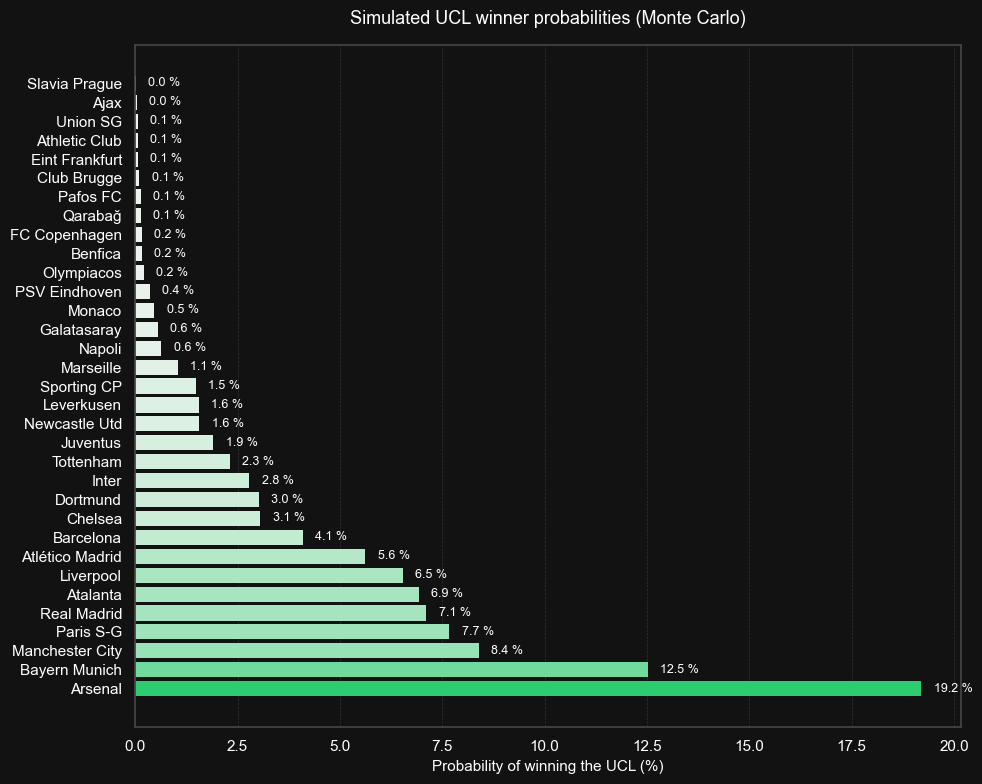

In [19]:
# Plot estimated title probabilities for the main contenders

plot_df = results.head(36).copy()
plot_df = plot_df.sort_values("Win_Probability", ascending=True)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["axes.facecolor"] = "#121212"
plt.rcParams["figure.facecolor"] = "#121212"
plt.rcParams["axes.edgecolor"] = "#444444"
plt.rcParams["axes.labelcolor"] = "white"
plt.rcParams["xtick.color"] = "white"
plt.rcParams["ytick.color"] = "white"
plt.rcParams["text.color"] = "white"

cmap = sns.light_palette("#2ecc71", as_cmap=True)
norm = plt.Normalize(
    plot_df["Win_Probability"].min(),
    plot_df["Win_Probability"].max()
)
colors = cmap(norm(plot_df["Win_Probability"].values))

fig, ax = plt.subplots()

bars = ax.barh(
    plot_df["Team"],
    plot_df["Win_Probability"] * 100,
    color=colors,
    edgecolor="none"
)

for bar, p in zip(bars, plot_df["Win_Probability"]):
    width = bar.get_width()
    ax.text(
        width + 0.3,
        bar.get_y() + bar.get_height() / 2,
        f"{p*100:.1f} %",
        va="center",
        ha="left",
        fontsize=9
    )

ax.set_xlabel("Probability of winning the UCL (%)", fontsize=11)
ax.set_ylabel("")
ax.set_title("Simulated UCL winner probabilities (Monte Carlo)", fontsize=13, pad=15)

ax.grid(axis="y", visible=False)
ax.grid(axis="x", color="#333333", linestyle="--", linewidth=0.5)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

#  <h1 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 2. Predicting top goalscorers

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 2.1 Load player data (all seasons) and basic cleaning

In [20]:
# Load all Champions League player statistics (multiple seasons)

all_players = pd.read_csv(
    "/Users/wed/Documents/cours L3 2025-2026/projet de recherche encadre/"
    "stats joueurs/Stat_players_UCL.csv",
    sep=";"
)

# Ensure seasons are treated consistently as strings
all_players["Season"] = all_players["Season"].astype(str)

# Simplify column names for minutes, goals and penalties
all_players.rename(columns={
    "Playing Time_MP": "MP",
    "Playing Time_Min": "Min",
    "Performance_Gls": "Gls",
    "Performance_PK": "PK_goals",
    "Performance_PKatt": "PK_att",
    "Squad": "Team",
    "Per 90 Minutes_Gls": "Gls_per90"
}, inplace=True)

season_current = "2025-26"
players_hist = all_players[all_players["Season"] != season_current].copy()
players_2526 = all_players[all_players["Season"] == season_current].copy()

# Make sure goals per 90 minutes exists for both historical and current data
# If missing, recompute Gls_per90 = goals / minutes * 90
for df in (players_hist, players_2526):
    df["Gls_per90"] = df["Gls_per90"].where(
        df["Gls_per90"].notna(),
        np.where(df["Min"] > 0, df["Gls"] / df["Min"] * 90, 0.0)
    )

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 2.2 Historical scoring and penalty aggregates

In [21]:
# Aggregate past Champions League performance for each player
# This gives a stable historical baseline for goals and penalties
hist_agg = (
    players_hist
    .groupby("Player")
    .agg(
        hist_minutes=("Min", "sum"),
        hist_goals=("Gls", "sum"),
        # Minutes-weighted historical goals per 90
        hist_gls_per90=("Gls", lambda g: (
            90 * g.sum() / players_hist.loc[g.index, "Min"].sum()
            if players_hist.loc[g.index, "Min"].sum() > 0 else 0.0
        )),
        hist_pk_goals=("PK_goals", "sum"),
        hist_pk_att=("PK_att", "sum"),
        hist_MP=("MP", "sum")   # total historical matches
    )
    .reset_index()
)

# Attach historical aggregates to current-season players
players_2526 = players_2526.merge(hist_agg, on="Player", how="left")

# Replace missing historical stats with 0 (new / unknown players)
players_2526[[
    "hist_minutes", "hist_goals", "hist_gls_per90",
    "hist_pk_goals", "hist_pk_att", "hist_MP"
]] = players_2526[[
    "hist_minutes", "hist_goals", "hist_gls_per90",
    "hist_pk_goals", "hist_pk_att", "hist_MP"
]].fillna(0.0)

# Historical minutes per match help to identify established “star” players
players_2526["hist_minutes_per_match"] = np.where(
    players_2526["hist_MP"] > 0,
    players_2526["hist_minutes"] / players_2526["hist_MP"],
    0.0
)

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 2.3 Smoothed goals per 90 (open‑play ability)

In [22]:
alpha = 0.6  # weight for current-season form vs historical level

# Blend current-season and historical goals per 90 to avoid overreacting to short samples
players_2526["Gls_per90_smooth"] = (
    alpha * players_2526["Gls_per90"] +
    (1 - alpha) * players_2526["hist_gls_per90"]
)

# Floor: do not let a big star fall below 70% of his historical scoring level
players_2526["Gls_per90_smooth"] = np.maximum(
    players_2526["Gls_per90_smooth"],
    0.7 * players_2526["hist_gls_per90"]
)

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 2.4 Projected minutes per match (role and injuries)

In [23]:
# Current-season minutes per match
players_2526["minutes_per_match"] = np.where(
    players_2526["MP"] > 0,
    players_2526["Min"] / players_2526["MP"],
    0.0
)

# Current-season starting rate (fraction of matches started)
players_2526["start_rate"] = np.where(
    players_2526["MP"] > 0,
    players_2526["Playing Time_Starts"] / players_2526["MP"],
    0.0
)

# Historical star: played enough matches and minutes per match in past seasons
players_2526["is_star_historical"] = (
    (players_2526["hist_MP"] >= 5) &
    (players_2526["hist_minutes_per_match"] >= 60)
)

# Injury info: number of matches missed in 2025–26
players_2526["injury_matches_missed"] = players_2526["injury_matches_missed"].fillna(0)

# Star clearly impacted by injury this season
players_2526["is_star_blessed"] = (
    players_2526["is_star_historical"] &
    (players_2526["injury_matches_missed"] >= 2)
)

def compute_minutes_future(row):
    """
    Estimate future minutes per match based on role and injury information.
    - star_blessed: historical star reduced by injuries, assume near full-time when fit
    - other historical star: mix of historical usage and current usage
    - normal starter: keep current minutes per match
    - substitute / fringe player: strongly reduced future minutes
    """
    # Case 1: historical star clearly impacted by injury
    if row["is_star_blessed"]:
        # Clamp between 75 and 90 minutes to reflect star status when available
        return min(max(row["hist_minutes_per_match"], 75.0), 90.0)

    # Case 2: other historical stars (no major injury)
    if row["is_star_historical"]:
        # Weighted average: mostly historical usage, slightly corrected by current usage
        base = 0.7 * row["hist_minutes_per_match"] + 0.3 * row["minutes_per_match"]
        return min(base, 90.0)

    # Case 3: normal player with decent playing time this season
    if row["Min"] >= 180 or row["start_rate"] >= 0.3:
        return row["minutes_per_match"]

    # Case 4: substitute / fringe player with very limited role
    return row["minutes_per_match"] * 0.4

# Projected minutes per match for the rest of the competition
players_2526["minutes_per_match_future"] = players_2526.apply(
    compute_minutes_future, axis=1
)

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 2.5 Expected number of remaining matches per team

In [24]:
# Use team-level Monte Carlo results to estimate how many matches each club still has to play
team_path = results[["Team", "expected_total_MP"]].copy()

players_2526 = players_2526.merge(team_path, on="Team", how="left")

# If a team is not in results: assume no extra matches beyond current MP
players_2526["expected_total_MP"] = players_2526["expected_total_MP"].fillna(
    players_2526["MP"]
)

# Expected matches remaining for each player's team
players_2526["expected_matches_remaining_team"] = (
    players_2526["expected_total_MP"] - players_2526["MP"]
).clip(lower=0)

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 2.6 Open‑play goals from non‑penalty xG

In [25]:
# Global mean non‑penalty xG per 90 minutes (used as prior for small samples)
mean_npxG_per90 = players_hist["Expected_npxG"].sum() * 90 / players_hist["Min"].sum()

k = 400  # shrinkage strength in minutes: small samples pulled toward global mean

# Shrink non‑penalty xG/90 towards the global average for players with few minutes
players_2526["npxG_per90_shrunk"] = np.where(
    players_2526["Min"] > 0,
    (players_2526["Min"] / (players_2526["Min"] + k)) * (
        players_2526["Expected_npxG"] / players_2526["Min"] * 90
    ) + (k / (players_2526["Min"] + k)) * mean_npxG_per90,
    mean_npxG_per90
)

# Finishing ratio: how many non‑penalty goals per non‑penalty xG
players_2526["finishing_ratio"] = np.where(
    players_2526["Expected_npxG"] > 0,
    (players_2526["Gls"] - players_2526["PK_goals"]) / players_2526["Expected_npxG"],
    1.0 # neutral finishing if no xG history
)

# Clip finishing ratio to avoid extremely unrealistic over/under-performance
players_2526["finishing_ratio"] = players_2526["finishing_ratio"].clip(0.5, 1.5)

# Expected open‑play goals from now to the end of the competition
lambda_open_play = (
    players_2526["npxG_per90_shrunk"] * players_2526["finishing_ratio"]
    * players_2526["minutes_per_match_future"]
    * players_2526["expected_matches_remaining_team"]
    / 90.0
)

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 2.7 Penalty goals projection

In [26]:
# Historical penalty record (current season + past seasons)
players_2526["pk_goals_hist_total"] = (
    players_2526["PK_goals"] + players_2526["hist_pk_goals"]
)
players_2526["pk_att_hist_total"] = (
    players_2526["PK_att"] + players_2526["hist_pk_att"]
)

# Long-run penalty conversion rate per player
players_2526["pk_conversion_rate"] = np.where(
    players_2526["pk_att_hist_total"] > 0,
    players_2526["pk_goals_hist_total"] / players_2526["pk_att_hist_total"],
    0.8  # prior if no penalty history (typical conversion rate)
)

# Approximate penalty intensity per team (average pens obtained per match in all seasons)
team_pk_per_match = 0.37

# Total penalties attempted by each club over all seasons
club_pk = (
    all_players
    .groupby("Team")["PK_att"]
    .sum()
    .rename("club_pk_att")
    .reset_index()
)

players_2526 = players_2526.merge(club_pk, on="Team", how="left")
players_2526["club_pk_att"] = players_2526["club_pk_att"].replace(0, np.nan)

# Probability that a player is the main penalty taker for his club
players_2526["prob_is_main_pk_taker"] = np.where(
    players_2526["club_pk_att"].notna() & (players_2526["pk_att_hist_total"] > 0),
    (players_2526["pk_att_hist_total"] / players_2526["club_pk_att"]).clip(0, 1),
    0.0
)

# Expected penalty goals from now to the end of the competition
lambda_pens = (
    team_pk_per_match
    * players_2526["expected_matches_remaining_team"]
    * players_2526["pk_conversion_rate"]
    * players_2526["prob_is_main_pk_taker"]
)

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 2.8 Poisson Monte Carlo simulation for top scorer

In [27]:
# Total expected remaining goals = open play + penalties
players_2526["lambda_remaining_goals"] = lambda_open_play + lambda_pens

# Expected final goal tally = goals already scored + expected remaining goals
players_2526["lambda_final_goals"] = (
    players_2526["Gls"] + players_2526["lambda_remaining_goals"]
)
players_sim = players_2526[players_2526["lambda_final_goals"] > 0].reset_index(drop=True)

lambdas = players_sim["lambda_final_goals"].values
n_players = lambdas.shape[0]
n_sim = 10000
rng = np.random.default_rng(42)

top_counts = np.zeros(n_players, dtype=float)

for _ in range(n_sim):
    # Simulate final goal counts for each player from a Poisson(lambda) distribution
    simulated_goals = rng.poisson(lam=lambdas)

    # Identify top scorer(s) in this simulation
    max_goals = simulated_goals.max()
    top_indices = np.where(simulated_goals == max_goals)[0]

    # If several players tie as top scorers, share the probability mass equally
    increment = 1.0 / len(top_indices)
    top_counts[top_indices] += increment

# Estimated probability of finishing as top scorer
players_sim["TopScorer_Prob"] = top_counts / n_sim

top_scorers_prob = players_sim.sort_values(
    "TopScorer_Prob", ascending=False
)[[
    "Player", "Team", "Pos",
    "Gls", "lambda_final_goals", "TopScorer_Prob", "minutes_per_match_future"
]]

print(top_scorers_prob.head(10))

                 Player             Team    Pos  Gls  lambda_final_goals  \
647       Kylian Mbappé      Real Madrid     FW    9           15.108439   
313      Victor Osimhen      Galatasaray     FW    6           10.164644   
433      Erling Haaland  Manchester City     FW    6           10.137128   
165          Harry Kane    Bayern Munich  FW,MF    5            9.048711   
46   Gabriel Martinelli          Arsenal     FW    5            8.823613   
524      Anthony Gordon    Newcastle Utd     FW    5            8.440416   
336    Lautaro Martínez            Inter     FW    4            7.348012   
117      Julián Álvarez  Atlético Madrid     FW    4            7.158858   
358      Dušan Vlahović         Juventus     FW    3            6.711135   
32         Noni Madueke          Arsenal     FW    3            6.235923   

     TopScorer_Prob  minutes_per_match_future  
647        0.639655                 86.007692  
313        0.098623                 75.000000  
433        0.086765

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 2.9 Visualizing top scorer probabilities

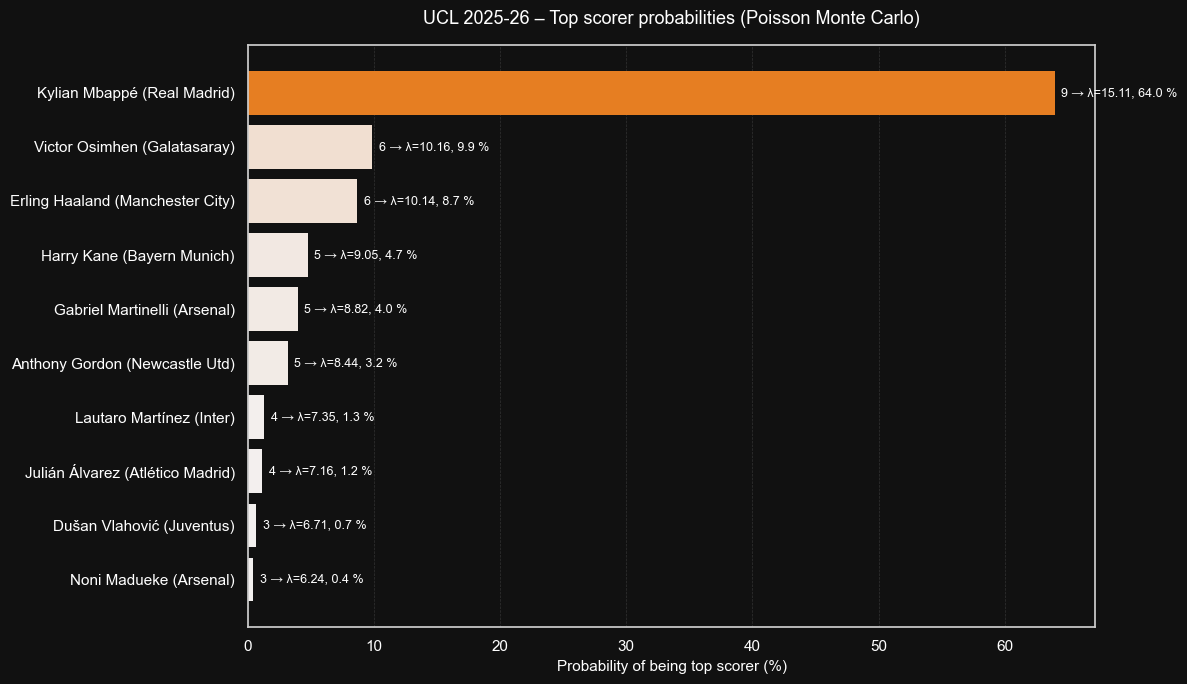

In [28]:
plot_df = top_scorers_prob.head(10).copy()
plot_df["label"] = plot_df["Player"] + " (" + plot_df["Team"] + ")"

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 7)
plt.rcParams["axes.facecolor"] = "#111111"
plt.rcParams["figure.facecolor"] = "#111111"
plt.rcParams["axes.labelcolor"] = "white"
plt.rcParams["xtick.color"] = "white"
plt.rcParams["ytick.color"] = "white"
plt.rcParams["text.color"] = "white"

fig, ax = plt.subplots()

cmap = sns.light_palette("#e67e22", as_cmap=True)
norm = plt.Normalize(plot_df["TopScorer_Prob"].min(), plot_df["TopScorer_Prob"].max())
colors = cmap(norm(plot_df["TopScorer_Prob"].values))

bars = ax.barh(
    plot_df["label"],
    plot_df["TopScorer_Prob"] * 100,
    color=colors,
    edgecolor="none"
)

for bar, gls_now, lam, p in zip(
    bars,
    plot_df["Gls"],
    plot_df["lambda_final_goals"],
    plot_df["TopScorer_Prob"]
):
    width = bar.get_width()
    ax.text(
        width + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f"{gls_now:.0f} → λ={lam:.2f}, {p*100:.1f} %",
        va="center",
        ha="left",
        fontsize=9
    )

ax.set_xlabel("Probability of being top scorer (%)", fontsize=11)
ax.set_ylabel("")
ax.set_title("UCL 2025-26 – Top scorer probabilities (Poisson Monte Carlo)", fontsize=13, pad=15)

ax.grid(axis="y", visible=False)
ax.grid(axis="x", color="#333333", linestyle="--", linewidth=0.5)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

#  <h1 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 3. Predicting top assisters

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 3.1 Assist per‑90 and historical aggregates

In [29]:
# Ensure assist-related per‑90 stats exist for both historical and current seasons
for df in (players_hist, players_2526):
    df["Ast_per90"] = np.where(
        df["Min"] > 0,
        df["Performance_Ast"] / df["Min"] * 90,
        0.0
    )

In [30]:
# Aggregate historical assist and xAG information per player
hist_assist = (
    players_hist
    .groupby("Player")
    .agg(
        hist_ast=("Performance_Ast", "sum"),
        # Minutes-averaged assists per 90 in past seasons
        hist_ast_per90=("Ast_per90", "mean"),
        hist_xAG=("Expected_xAG", "sum")
    )
    .reset_index()
)

# Merge historical assist stats into current-season player table
players_2526 = players_2526.merge(hist_assist, on="Player", how="left")
players_2526[["hist_ast", "hist_ast_per90", "hist_xAG"]] = (
    players_2526[["hist_ast", "hist_ast_per90", "hist_xAG"]].fillna(0.0)
)

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 3.2 Smoothed assist rate and xAG shrinkage

In [31]:
alpha_ast = 0.6  # balance between current-season and historical assist form

# Current-season assists per 90 minutes
players_2526["Ast_per90_curr"] = np.where(
    players_2526["Min"] > 0,
    players_2526["Performance_Ast"] / players_2526["Min"] * 90,
    0.0
)

# Smoothed assist rate combining current and historical per‑90 numbers
players_2526["Ast_per90_smooth"] = (
    alpha_ast * players_2526["Ast_per90_curr"] +
    (1 - alpha_ast) * players_2526["hist_ast_per90"]
)

# Optional floor: regular creators do not drop below 70% of their historical level
players_2526["Ast_per90_smooth"] = np.maximum(
    players_2526["Ast_per90_smooth"],
    0.7 * players_2526["hist_ast_per90"]
)

In [32]:
# Raw expected assists per 90 minutes
players_2526["xAG_per90"] = np.where(
    players_2526["Min"] > 0,
    players_2526["Expected_xAG"] / players_2526["Min"] * 90,
    0.0
)

# Global mean xAG per 90, used as a prior for players with few minutes
mean_xAG_per90 = players_hist["Expected_xAG"].sum() * 90 / players_hist["Min"].sum()

k_ast = 400  # shrinkage strength in minutes (pull small samples toward the mean)

# Shrink xAG/90 towards the global mean to avoid overreacting to tiny samples
players_2526["xAG_per90_shrunk"] = np.where(
    players_2526["Min"] > 0,
    (players_2526["Min"] / (players_2526["Min"] + k_ast)) * players_2526["xAG_per90"]
    + (k_ast / (players_2526["Min"] + k_ast)) * mean_xAG_per90,
    mean_xAG_per90
)

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 3.3 Future minutes adjustment for low‑usage players

In [33]:
# Share of minutes already played this season (900 ≈ 10 full matches)
players_2526["share_minutes_played"] = np.clip(
    players_2526["Min"] / 900.0,
    0.0,
    1.0
)

# Damp future minutes for players who have barely played so far
players_2526["future_minutes_factor"] = np.where(
    players_2526["share_minutes_played"] < 0.2,  # less than 20% of possible minutes
    0.3,                                        # they only get 30% of theoretical future time
    1.0
)

# Adjusted projected minutes per match used for assist projections
players_2526["minutes_per_match_future_adj"] = (
    players_2526["minutes_per_match_future"] * players_2526["future_minutes_factor"]
)

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 3.4 Assist rate model and remaining assists

In [34]:
# Current assists per 90 minutes
players_2526["Ast_per90_curr"] = np.where(
    players_2526["Min"] > 0,
    players_2526["Performance_Ast"] / players_2526["Min"] * 90,
    0.0
)

# Combine xAG-based creation and realised assists into a single assist rate
w_xAG = 0.7 # main signal: underlying chance creation
w_ast = 0.3 # secondary signal: realised assists

players_2526["assist_rate_per90"] = (
    w_xAG * players_2526["xAG_per90_shrunk"] +
    w_ast * players_2526["Ast_per90_curr"]
)

# Confidence factor based on minutes played: very small samples are down-weighted
players_2526["rate_confidence"] = np.clip(
    players_2526["Min"] / 900.0,
    0.1,
    1.0
)

players_2526["assist_rate_per90_conf"] = (
    players_2526["assist_rate_per90"] * players_2526["rate_confidence"]
)


# Expected number of assists from now to the end of the competition
lambda_assists_remaining = (
    players_2526["assist_rate_per90"]
    * players_2526["minutes_per_match_future_adj"]
    * players_2526["expected_matches_remaining_team"]
    / 90.0
)

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 3.5 Poisson Monte Carlo simulation for top assister

In [35]:
# Total expected final assists = current assists + expected remaining assists
players_2526["lambda_final_assists"] = (
    players_2526["Performance_Ast"] + lambda_assists_remaining
)

In [36]:
players_ast_sim = players_2526[players_2526["lambda_final_assists"] > 0].reset_index(drop=True)

lambdas_ast = players_ast_sim["lambda_final_assists"].values
n_players_ast = lambdas_ast.shape[0]
n_sim_ast = 10000
rng_ast = np.random.default_rng(123)

top_counts_ast = np.zeros(n_players_ast, dtype=float)

for _ in range(n_sim_ast):
    # Simulate final assist counts for each player from a Poisson(lambda) distribution
    simulated_ast = rng_ast.poisson(lam=lambdas_ast)

    # Identify top assister(s) in this simulation
    max_ast = simulated_ast.max()
    top_idx = np.where(simulated_ast == max_ast)[0]

    # If several players tie, share the probability mass equally between them (same as top goalscorer)
    incr = 1.0 / len(top_idx)
    top_counts_ast[top_idx] += incr

# Estimated probability of finishing as top assister
players_ast_sim["TopAssist_Prob"] = top_counts_ast / n_sim_ast

top_assisters_prob = players_ast_sim.sort_values(
    "TopAssist_Prob", ascending=False
)[[
    "Player", "Team", "Pos",
    "Performance_Ast", "lambda_final_assists", "TopAssist_Prob",
    "minutes_per_match_future"
]]

print(top_assisters_prob.head(10))

                        Player             Team    Pos  Performance_Ast  \
573              Achraf Hakimi        Paris S-G     DF                3   
456  Pierre-Emerick Aubameyang        Marseille     FW                4   
156               Serge Gnabry    Bayern Munich  FW,MF                3   
363               Kenan Yıldız         Juventus     MF                3   
161              Michael Olise    Bayern Munich  FW,MF                3   
407         Dominik Szoboszlai        Liverpool  MF,DF                3   
430          Tijjani Reijnders  Manchester City     MF                3   
486            Kevin De Bruyne           Napoli  MF,FW                2   
163              Konrad Laimer    Bayern Munich     DF                3   
41            Martín Zubimendi          Arsenal     MF                2   

     lambda_final_assists  TopAssist_Prob  minutes_per_match_future  
573              5.831995        0.134285                 83.207143  
456              5.333762        0

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 3.6 Visualizing top assister probabilities

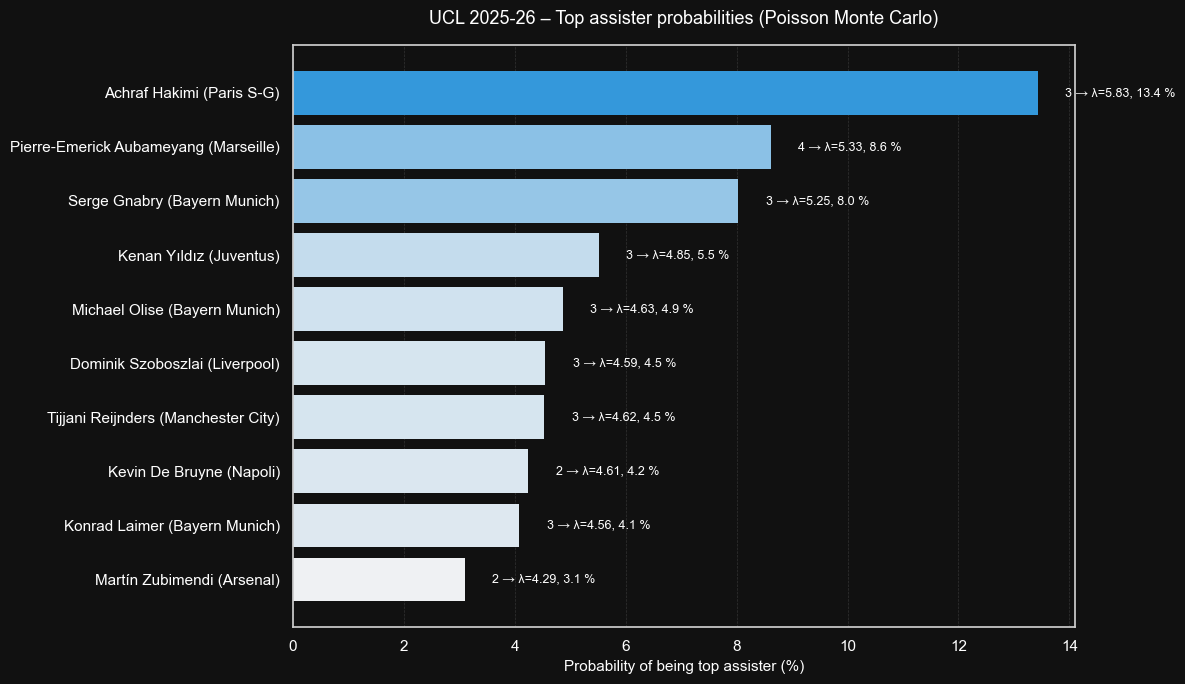

In [37]:
plot_ast = top_assisters_prob.head(10).copy()
plot_ast["label"] = plot_ast["Player"] + " (" + plot_ast["Team"] + ")"

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 7)
plt.rcParams["axes.facecolor"] = "#111111"
plt.rcParams["figure.facecolor"] = "#111111"
plt.rcParams["axes.labelcolor"] = "white"
plt.rcParams["xtick.color"] = "white"
plt.rcParams["ytick.color"] = "white"
plt.rcParams["text.color"] = "white"

fig, ax = plt.subplots()

cmap = sns.light_palette("#3498db", as_cmap=True)
norm = plt.Normalize(plot_ast["TopAssist_Prob"].min(), plot_ast["TopAssist_Prob"].max())
colors = cmap(norm(plot_ast["TopAssist_Prob"].values))

bars = ax.barh(
    plot_ast["label"],
    plot_ast["TopAssist_Prob"] * 100,
    color=colors,
    edgecolor="none"
)

for bar, ast_now, lam, p in zip(
    bars,
    plot_ast["Performance_Ast"],
    plot_ast["lambda_final_assists"],
    plot_ast["TopAssist_Prob"]
):
    width = bar.get_width()
    ax.text(
        width + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f"{ast_now:.0f} → λ={lam:.2f}, {p*100:.1f} %",
        va="center",
        ha="left",
        fontsize=9
    )

ax.set_xlabel("Probability of being top assister (%)", fontsize=11)
ax.set_ylabel("")
ax.set_title("UCL 2025-26 – Top assister probabilities (Poisson Monte Carlo)", fontsize=13, pad=15)

ax.grid(axis="y", visible=False)
ax.grid(axis="x", color="#333333", linestyle="--", linewidth=0.5)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

#  <h1 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 4. Predicting player of the tournament

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 4.1 Individual contribution from goals and assists

In [38]:
# Start from the same player table used for top scorer / top assister projections
players_mvp = players_2526.copy()

# Baseline individual contribution: expected final goals and assists (λ_goals, λ_assists)
players_mvp["MVP_GA"] = (
    1.0 * players_mvp["lambda_final_goals"] +
    0.7 * players_mvp["lambda_final_assists"]
)
# Non-linear boost: heavily reward very high combined goals + assists totals
players_mvp["MVP_GA_nonlinear"] = players_mvp["MVP_GA"] ** 1.25

# Individual MVP score, down‑weighting players with very few minutes played
players_mvp["MVP_indiv_score"] = players_mvp["MVP_GA_nonlinear"] * np.clip(
    players_mvp["Min"] / 1200.0,
    0.4,
    1.0
)

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 4.2 Linking individual impact to team success

In [39]:
# Team-level title probabilities from the winner Monte Carlo simulation
team_probs = results[["Team", "Win_Probability"]].copy()
team_probs["Team"] = team_probs["Team"].str.strip()

players_mvp["Team"] = players_mvp["Team"].str.strip()
players_mvp = players_mvp.merge(team_probs, on="Team", how="left")

players_mvp["Win_Probability"] = players_mvp["Win_Probability"].fillna(0.0)

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 4.3 Final MVP score and ranking

In [40]:
alpha = 0.6 # controls how strongly very high title probabilities are rewarded

# Smoothed version of the title probability:
# mix between p and sqrt(p) so that 50% vs 20% still makes a clear difference
players_mvp["WinProb_smoothed"] = (
    alpha * players_mvp["Win_Probability"] +
    (1 - alpha) * players_mvp["Win_Probability"].pow(0.5)
)

# Final MVP score = individual production × (smoothed) probability of winning the tournament
players_mvp["MVP_score"] = (
    players_mvp["MVP_indiv_score"] * players_mvp["WinProb_smoothed"]
)

# Top MVP candidates
top_mvp = players_mvp.sort_values("MVP_score", ascending=False)[[
    "Player", "Team", "Pos",
    "lambda_final_goals",
    "lambda_final_assists",
    "MVP_indiv_score",
    "Win_Probability",
    "MVP_score"
]].head(10)

print(top_mvp)

                 Player             Team    Pos  lambda_final_goals  \
46   Gabriel Martinelli          Arsenal     FW            8.823613   
681       Kylian Mbappé      Real Madrid     FW           15.108439   
165          Harry Kane    Bayern Munich  FW,MF            9.048711   
449      Erling Haaland  Manchester City     FW           10.137128   
32         Noni Madueke          Arsenal     FW            6.235923   
44          Bukayo Saka          Arsenal     FW            4.194497   
40      Viktor Gyökeres          Arsenal     FW            5.243264   
152           Luis Díaz    Bayern Munich     FW            6.094777   
117      Julián Álvarez  Atlético Madrid     FW            7.158858   
35     Leandro Trossard          Arsenal     FW            2.307266   

     lambda_final_assists  MVP_indiv_score  Win_Probability  MVP_score  
46               2.247111         7.467473           0.1920   2.169086  
681              1.065596        12.654523           0.0711   1.889552  

###  <h2 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 4.4 Visualizing MVP score distribution

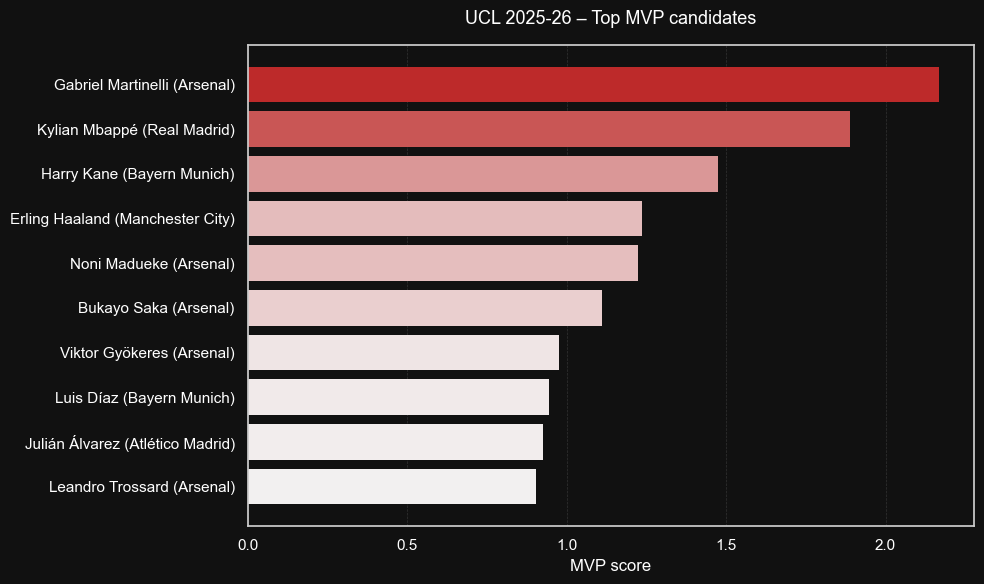

In [48]:
plot_df = players_mvp.sort_values("MVP_score", ascending=False).head(10).copy()
plot_df["label"] = plot_df["Player"] + " (" + plot_df["Team"] + ")"

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.facecolor"] = "#111111"
plt.rcParams["figure.facecolor"] = "#111111"
plt.rcParams["axes.labelcolor"] = "white"
plt.rcParams["xtick.color"] = "white"
plt.rcParams["ytick.color"] = "white"
plt.rcParams["text.color"] = "white"

fig, ax = plt.subplots()

cmap = sns.light_palette("#BD2A2A", as_cmap=True)
norm = plt.Normalize(plot_df["MVP_score"].min(), plot_df["MVP_score"].max())
colors = cmap(norm(plot_df["MVP_score"].values))

bars = ax.barh(
    plot_df["label"],
    plot_df["MVP_score"],
    color=colors,
    edgecolor="none"
)

ax.invert_yaxis()

ax.set_xlabel("MVP score")
ax.set_ylabel("")
ax.set_title("UCL 2025-26 – Top MVP candidates", fontsize=13, pad=15)

ax.grid(axis="y", visible=False)
ax.grid(axis="x", color="#333333", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()


#  <h1 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 5. Save the results as CSV

In [42]:
top20_winner = results.sort_values("Win_Probability", ascending=False).head(20)
logo_map = {
    "Arsenal": "Arsenal.png",
    "Bayern Munich": "Bayern Munich.png",
    "Manchester City": "Manchester City.png",
    "Paris S-G": "Paris S-G.png",
    "Real Madrid": "Real Madrid.png",
    "Atalanta": "Atalanta.png",
    "Liverpool": "Liverpool.png",
    "Atlético Madrid": "Atlético Madrid.png",
    "Barcelona": "Barcelona.png",
    "Chelsea": "Chelsea.png",
    "Dortmund": "Dortmund.png",
    "Inter": "Inter.png",
    "Tottenham": "Tottenham.png",
    "Juventus": "Juventus.png",
    "Newcastle Utd": "Newcastle Utd.png",
    "Leverkusen": "Leverkusen.png",
    "Sporting CP": "Sporting CP.png",
    "Marseille": "Marseille.png",
    "Napoli": "Napoli.png",
    "Galatasaray": "Galatasaray.png",
}

top20_winner["LogoFile"] = top20_winner["Team"].map(logo_map)

top20_winner.to_csv(
    "ucl_winner_top20.csv",
    index=False,
    encoding="utf-8"
)

In [43]:
players_sim_small = players_sim[["Player", "Team", "TopScorer_Prob"]].copy()
players_sim_small["Player"] = players_sim_small["Player"].str.strip()
players_sim_small["Team"] = players_sim_small["Team"].str.strip()

players_2526["Player"] = players_2526["Player"].str.strip()
players_2526["Team"] = players_2526["Team"].str.strip()

players_2526 = players_2526.merge(
    players_sim_small,
    on=["Player", "Team"],
    how="left"
)


In [44]:
top10_scorer = players_2526.sort_values("TopScorer_Prob", ascending=False).head(10)[[
    "Player", "Team", "Pos",
    "Gls", "lambda_final_goals", "TopScorer_Prob"
]]

top10_scorer["LogoFile"] = top10_scorer["Team"].map(logo_map)

top10_scorer.to_csv(
    "ucl_top_scorer_top10.csv",
    index=False,
    encoding="utf-8"
)

In [45]:
players_sim_small = players_ast_sim[["Player", "Team", "TopAssist_Prob"]].copy()
players_sim_small["Player"] = players_sim_small["Player"].str.strip()
players_sim_small["Team"] = players_sim_small["Team"].str.strip()

players_2526["Player"] = players_2526["Player"].str.strip()
players_2526["Team"] = players_2526["Team"].str.strip()

players_2526 = players_2526.merge(
    players_sim_small,
    on=["Player", "Team"],
    how="left"
)

In [46]:
top10_assist = players_2526.sort_values("TopAssist_Prob", ascending=False).head(10)[[
    "Player", "Team", "Pos",
    "Performance_Ast", "lambda_final_assists", "TopAssist_Prob"
]]

top10_assist["LogoFile"] = top10_assist["Team"].map(logo_map)

top10_assist.to_csv(
    "ucl_top_assist_top10.csv",
    index=False,
    encoding="utf-8"
)

In [47]:
top10_mvp = players_mvp.sort_values("MVP_score", ascending=False).head(10)[[
    "Player", "Team", "Pos",
    "lambda_final_goals",
    "lambda_final_assists",
    "MVP_indiv_score",
    "Win_Probability",
    "MVP_score"
]]

top10_mvp["LogoFile"] = top10_mvp["Team"].map(logo_map)

top10_mvp.to_csv(
    "ucl_mvp_top10.csv",
    index=False,
    encoding="utf-8"
)